# **IEOR 4650  Business Analytics (Fall 2019)**

**Homework 2 [Total points: 60]**

** Due: 11:59 PM, October 8**

This second homework consists of Python programming practices and the applications to linear regression. 

The steps to finish in the homework:

*   Step 1: Make a copy of the file to your LionDrive.
*   Step 2: Work with the copy (an ipynb file).
*    <font color='red'>**Step 3: Rename the copy to your_uni_hw2.ipynb (For example: yd4501_hw2.ipynb).**</font>  
*   Step 4: Submit the copy on CourseWorks.

Before you submit your assignment, make sure to re-run your code from the beginning. (You can do so by first clicking Runtime/Reset All Runtimes and then clicking Runtime/Run all)


**All the questions in this homework requires coding**

In [0]:
#This imports all the packages you need for the homework
#Please run this first


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


#import modules

import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt




##Setting
In this exercise, let's continue working with a dataset which explores the store sales.

Before doing the assignment, please study this dataset here https://www.kaggle.com/c/rossmann-store-sales/data


For this study, we are interested in finding a good model that gives good prediction performance. 

* Especially, we are interested in use RMSPE as our accuracy measurement. RMSPE is defined as following:
$$RMSPE = \sqrt{\frac{\frac{(y_i-\widehat{y_i}}{y_i})^2}{N}}$$
* In addition, any day and store with 0 actual sales is ignored in scoring.

In [0]:
#Load the dataset
link="https://drive.google.com/open?id=1Q6J0q4tlWJ7TajX6hMSvZ8tK3CyDD8QY"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Sales.csv')  
SALE = pd.read_csv('Sales.csv')
SALE.head(5)



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


*You might see a warning when importing the data. This is because StateHoliday has both values in string and numbers. No worries this for now.*

In [0]:
link="https://drive.google.com/open?id=1g6URzUJnhCLOtg0a9TTHC18KYcqwxvoc"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('myfile_store.csv')  
STORE = pd.read_csv('myfile_store.csv')
STORE.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Q1. [8 points]
**[Data Cleaning]**

1. Merge two tables based on "Store" column

2. To save you from the pain of running the models for too long, **keep only records for store 1-100**.

3. This study only cares about the accuracy performend on the data with Sales higher than 0.There are pros and cons of keeping 0 Sales records. For this study, let's **delete all the sales records with sales=0**.

4. Print out the unique values you have in "StateHoliday" column. If you see anything that goes wrong, fix the issue. After that, print out the unique values again in "StateHoliday" column. [You might find this [link](https://www.geeksforgeeks.org/python-pandas-series-str-replace-to-replace-text-in-a-series/) useful]


In [0]:
SALE=SALE.merge(STORE) #1 point
SALE=SALE.astype({"Date":"datetime64"}) 
SALE=SALE[SALE["Sales"]>0] #2 point
SALE=SALE[(SALE["Store"]>=1) & (SALE["Store"]<=100)] #2 points
print(SALE["StateHoliday"].value_counts()) #1 point
print(SALE["StateHoliday"].replace(0,"0").value_counts()) #2 points
#students can replace "0" with 0 or 0 with "0". As along as they did converge 0 and "0"
#to the same category, we give them full points


0    65510
0    10020
a       51
b        6
c        4
Name: StateHoliday, dtype: int64
0    75530
a       51
b        6
c        4
Name: StateHoliday, dtype: int64


## Q2 [4 points]

**[Preparation for cross-validation]**

Split our data into three segments.Instead of shuffling them first, we will do something different. When working with prediction, we might want to have a model that can give good prediction power for the future sales. Thus, we will split our data in the following way:

(1) Training: Time window 2013-01-01 to 2015-03-31  

(2) Validation: Time window 2015-04-01 to 2015-05-31 

(3) Testing: Time window 2015-06-01 to 2015-07-31

Print out how many records you have for each set.

In [0]:
#You might find the following sample code helpful 
#X=X.astype({"Date":"datetime64"})
#X["Date"]<"2015-01-02"

#split the data (2 points)
SALE_Training=SALE[SALE["Date"]<="2015-03-31"]
SALE_Validation=SALE[(SALE["Date"]>="2015-04-01") & (SALE["Date"]<="2015-05-31")]
SALE_Testing=SALE[SALE["Date"]>="2015-06-01"]

#print out the number of records (2 points)
#If students do not have these three numbers, something must be wrong
#If the mistake is made because of Q1, we will not deduct points again for this question
#If the mistake is made because of Q2, we will deduct points for data splitting
print(SALE_Training.shape[0], SALE_Validation.shape[0], SALE_Testing.shape[0])


65631 4715 5245


##Q3 [8 points]

**[Feature Engineering 1 ]**

Usually, people pay great attention to the features that are highly predictive. Making sure that adequate variable transformations are performed on those variables are highly important. 

* Examine why customer numbers is an important predictor based on the data.

* Use 4 histograms show how taking the log-transformation changes the distribution of "Sales" and "Customers" on the training set. Make layout the 4 histograms following the following format

\begin{bmatrix}
    \text{Sales plot here} &  \text{log(Sales) plot here} \\
    \text{Customer plot here} &  \text{log(Customer) plot here}
\end{bmatrix}.

>You will find this [link](https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html) useful

2. 
  Based on cross-validation to show which model gives a better performance. 
  $$log(Sales)=\beta_0+\beta_1 log(Customers)+\epsilon$$ 
  $$Sales=\beta_0+\beta_1 Customers+\epsilon$$ 


[[1.         0.83601357]
 [0.83601357 1.        ]]
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                 1.523e+05
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        21:24:50   Log-Likelihood:            -5.6991e+05
No. Observations:               65631   AIC:                         1.140e+06
Df Residuals:                   65629   BIC:                         1.140e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I

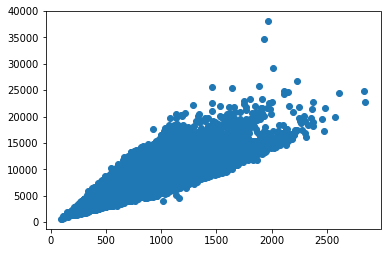

In [0]:
#[2 points]
#Version 1
plt.scatter(SALE_Training["Customers"],SALE_Training["Sales"])
#Very clear strong linear relationship. Yes a good predictor

#Version 2
print(np.corrcoef(SALE_Training["Customers"],SALE_Training["Sales"]))
#The correlation coefficient is 0.84. Yes good predictor

#Version 3
formula1="Sales~Customers"
print(ols(formula=formula1,data=SALE_Training).fit().summary())
#R2 is 0.7, which is an indicator of potentially good fitting

#If you see a student discussing beta value or p-value. Deduct 0.5 points. 

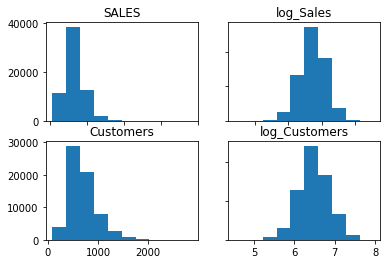

In [0]:
#Visualization [3 points]
#If the student did not use histogram, deduct 2 points
#If student did not give title to each subplot, let me know that they should have title to differentiate, but do not deduct points

fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(SALE_Training["Sales"])
axs[0, 0].set_title('SALES')
axs[0, 1].hist(np.log(SALE_Training["Sales"]))
axs[0, 1].set_title('log_Sales')
axs[1, 0].hist(SALE_Training["Customers"])
axs[1, 0].set_title('Customers')
axs[1, 1].hist(np.log(SALE_Training["Customers"]))
axs[1, 1].set_title('log_Customers')

# Hide x labels and tick labels for top plots and y ticks for right plots.


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [0]:
# Model selection: [4 points]
#2 points estimate the models
formula1="Sales~Customers"
formula2="np.log(Sales)~np.log(Customers)"
prediction1=ols(formula=formula1,data=SALE_Training).fit().predict(SALE_Validation)
prediction2=ols(formula=formula2,data=SALE_Training).fit().predict(SALE_Validation)
#0.5 point, expoentiate
prediction2=np.exp(prediction2)

actual=SALE_Validation["Sales"].values

#1 point [students might make mistakes in parantheses. Deduct 0.5 if you see a mistake]
RMSPE1=(np.mean(((prediction1-actual)/actual)**2))**0.5
RMSPE2=(np.mean(((prediction2-actual)/actual)**2))**0.5

print(RMSPE1, RMSPE2)
#0.5 points [give a better model which corresponds to low RMSPE]
#the second model is better

#If you see these two RMSPEs, full points will directly be given.
#If RMSPE look different, you need to check what is going wrong.
#If it is due to data processing, let the students know their result is wrong due to Q1/Q2, but do not deduct points
#If it is due to model estimating, deduct points based on how serious the mistakes are. 
 

0.2003944782371701 0.1936640852398272


##Q4 [7 points]

**[Feature Engineering 2]**

In the business operation, stores performance can vary with time. Including the time/date information can potentially help us increase the model fit. Some typical factors we can consider are:

* Year [store performance in 1992 can be different from the performance in 2010]
* Month [For example, an ice-cream shop generally have higher sales in the summer months]
* Day of the week [Especially, weekend v.s. weekdays might show very differen performances]
* Important events

In our dataset, we have "DayOfWeek", "SchoolHoliday" and "StateHoliday" to capture the last two factors. However, we do not have the "Year" and "Month".

Luckily, once we specify "Date" as the datetime type. We can easily extract the time information. See the link [here](https://pandas.pydata.org/pandas-docs/stable/reference/series.html#datetimelike-properties)

For Q4: Do the following 

* Argue the pros and cons of adding Month as a categorical variable v.s. continuous variable.
* Determine the best decision using cross-validation.


In [0]:
#Q1 [3 points]

#Adding "Month" as a categorial variable means every month is expected to have different sales, which means sense. However, at the same time, it adds 11 additional variables
#It could potentially lead to overfitting, especially when many months show no difference from one another. 
#Adding "Month" as a continuous variable might help if we assume that as the month increases, the sales tend to go higher/lower. If this is true, then 
#adding "Month" as a continuous variable will only add 1 more variable, which means less burden. At the same time, it might be hard 
#to see why linear relationship actually exisits

#[1 points] categorical variable makes intuitive sense, because we usually would assume that month/log(sales) relationship is not linear. It can help us model each month separately
#[1 points] directly added 11 dummy variables, which could lead to overfit. however, treating it as continuous will only add 1 variable (2 if you want to add polynomial)
#[1 points] continuous variable will partially capture the relationship if end of the year sells more (or less)
#comparing to the earlier year


In [0]:
#[5 points]
#Suppose x3 is a datetype column. If you want to get year information and treat it as a continuous variable in the regression, you can simply do
#(y~x1+x2+x3.dt.month,data=Data)

#3 points
#[if ]
formula1="np.log(Sales)~np.log(Customers)"
formula2="np.log(Sales)~np.log(Customers)+Date.dt.month"
formula3="np.log(Sales)~np.log(Customers)+C(Date.dt.month)"

prediction1=ols(formula=formula1,data=SALE_Training).fit().predict(SALE_Validation)
prediction2=ols(formula=formula2,data=SALE_Training).fit().predict(SALE_Validation)
prediction3=ols(formula=formula3,data=SALE_Training).fit().predict(SALE_Validation)
 
prediction1=np.exp(prediction1)
prediction2=np.exp(prediction2)
prediction3=np.exp(prediction3)



#1 point 
actual=SALE_Validation["Sales"].values
RMSPE1=(np.mean(((prediction1-actual)/actual)**2))**0.5
RMSPE2=(np.mean(((prediction2-actual)/actual)**2))**0.5
RMSPE3=(np.mean(((prediction3-actual)/actual)**2))**0.5



print(RMSPE1, RMSPE2, RMSPE3)
# 1 point
#We can see that treating month as a categorial variable is the best option as 
#it leads to lower RMSPE


#Grading tip:

#You might see students including other time factors as well 
#You might also see students not including log(customers)
#in these two cases, if everything else is correct, we give them full points 


0.1936640852398272 0.1933814837419038 0.19316459641919098


##Q5 [10 points]
### [Forward Model Selection]

Time to practice some model selection technique. Let's suppose that we want to determine some predictors we would like to adding based on the baseline model you chose in **Q3**. [To reduce your coding complexity, let's simply consider the following three factors]

* Promo	
* Promo2
* SchoolHoliday


Based on cross-validation, choose the best model. 
* Report RMSPE of each model and the new variable to be selected in each round of model selection
[You can do this manually]

* After selecting the final model, report the accuracy on the test set.

In [0]:
#round 1 [3 points]
formula1="np.log(Sales)~np.log(Customers)+Promo"
formula2="np.log(Sales)~np.log(Customers)+Promo2"
formula3="np.log(Sales)~np.log(Customers)+SchoolHoliday"

prediction1=np.exp(ols(formula=formula1,data=SALE_Training).fit().predict(SALE_Validation))
prediction2=np.exp(ols(formula=formula2,data=SALE_Training).fit().predict(SALE_Validation))
prediction3=np.exp(ols(formula=formula3,data=SALE_Training).fit().predict(SALE_Validation))
actual=SALE_Validation["Sales"]
RMSPE1=(np.mean(((prediction1-actual)/actual)**2))**0.5
RMSPE2=(np.mean(((prediction2-actual)/actual)**2))**0.5
RMSPE3=(np.mean(((prediction3-actual)/actual)**2))**0.5


print(RMSPE1, RMSPE2, RMSPE3)
print("We will add Promo to the next round")

#round 2 [2 points]

formula1="np.log(Sales)~np.log(Customers)+Promo+Promo2"
formula2="np.log(Sales)~np.log(Customers)+Promo+SchoolHoliday"

prediction1=np.exp(ols(formula=formula1,data=SALE_Training).fit().predict(SALE_Validation))
prediction2=np.exp(ols(formula=formula2,data=SALE_Training).fit().predict(SALE_Validation))

RMSPE1=(np.mean(((prediction1-actual)/actual)**2))**0.5
RMSPE2=(np.mean(((prediction2-actual)/actual)**2))**0.5

print(RMSPE1, RMSPE2)
print("We will add School Holiday to the next round")

#round 3 [2 points]

formula1="np.log(Sales)~np.log(Customers)+Promo+SchoolHoliday+Promo2"
prediction1=np.exp(ols(formula=formula1,data=SALE_Training).fit().predict(SALE_Validation))
RMSPE1=(np.mean(((prediction1-actual)/actual)**2))**0.5
print(RMSPE1)
print("We will not add Promo2 to the set")


#Final accuracy [3 points]
prediction1=np.exp(ols(formula=formula1,data=SALE_Training).fit().predict(SALE_Testing))
actual_testing=SALE_Testing["Sales"]
RMSPE_testing=(np.mean(((prediction1-actual_testing)/actual_testing)**2))**0.5
print(RMSPE_testing)

print("Final accuracy on testing is:", RMSPE_testing)


#If you see a student trying to test with interaction terms as well. Give the student full points if it is done correctly
#If you see did not do a forward selection, but tested all of the possible combinations. Deduct 3 points if everything else is correct



0.17829789604366167 0.19374146955375174 0.19374863155526667
We will add Promo to the next round
0.17834241107914753 0.17821283492510295
We will add School Holiday to the next round
0.1782580731402105
We will not add Promo to the set
0.18458907855288836
Final accuracy on testing is: 0.18458907855288836


##Q6 [10 points]
###[Ridge regression]

When working with dataset (especially if we are using many predictors for a small dataset), we might encounter some serious problem with over-fitting.

To demonstrate how to use Ridge regression to deal with this problem. We will explore a setting when we have very limited data. In this dataset, let's simply use the information from **Store 3** from 2013-01-02 to 2013-02-18. 

Again, we will split our data into three segments based on the date.

* Training: Information for Store 3 before 2013-02-02
* Validation: Information for Store 3 between 2013-02-2 and 2013-02-12-11
* Testing: Information from Store 3 between 2013-02-12 and 2013-02-18


Conduct ridge regression on the training set. 

Assume the model you want to run is 
$$log(Sale)=\beta_0+\beta_1 log (Customers) + \beta_2 Customers +\epsilon$$


* Plot the relationship between $\alpha$ and RMSPE on the Validation set. 


In [0]:
#[3 points]
SALE1=SALE[(SALE["Store"]==3)&(SALE["Date"]<="2013-02-18" )]
SALE1_Training=SALE1[SALE1["Date"]<="2013-02-01"]
SALE1_Validation=SALE1[(SALE1["Date"]>="2013-02-02") & (SALE1["Date"]<="2013-02-11")]
SALE1_Testing=SALE1[(SALE1["Date"]>="2013-02-12")  ]


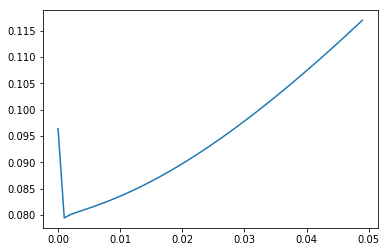

In [0]:
#[5 points]

model="np.log(Sales)~np.log(Customers)+I(Customers)"
actual=SALE1_Validation["Sales"]

def function(alpha_value):
  prediction1=ols(model,data=SALE1_Training).fit_regularized(alpha=alpha_value, L1_wt=0).predict(SALE1_Validation)
  prediction1=np.exp(prediction1)
  A1=(np.mean(((prediction1-actual)/actual)**2))**0.5
  return A1

#[2 points]
#If the student chose a different range to explore, that is fine. We need to see this V shaped curve in the graph
alpha_array= np.arange(0.0,0.05,0.001)
RSMPE_array=[function(alpha) for alpha in alpha_array]
plt.plot(alpha_array,RSMPE_array)
plt.show()




##Q7. [13 points]
###[Standardization in ridge regression]
The previous model gives an okay solution. However, one thing to notice is that the scale of variations could also affect $\beta$ values, which can cause factors to be discriminated simply based on whether the values are small or large. In addition, we do not want $\beta_0$ to be penalized.

As a result, people usually standardize the variables. Especially, for Ridge regression, a common practice is to do the following:

**On the training set:**

1. Standardize each independent variable using 

$$\frac{x_k-\bar{x_k}}{s_{x_k}}$$

where $\bar{x}$ and $s_x$ are the mean and the standard deviation of variable $x_k$ on the training set. 


2. Re-center the dependent variable using 

$$y-\bar{y}$$

where $\bar{y}$ is the mean of $y$ on the training set.

This allows us to tease out the impact of $\beta_0$ in the regulation

3. Regress the de-centered depedent variable on the standardized independent variables without intercept. [you can simply use "y~x1+x2-1" to not estimate the intercept]

**On the validation and testing set:**

When you do the prediction on the validation set, we will have

$$\hat{y}=\bar{y}+\sum \hat{\beta_k} {\frac{x-\bar{x_k}}{s_{x_k}}}$$

where $\bar{y}$ is the mean of $y$ on the **training set**, $\bar{x_k}$ is the mean of $x_k$ on the **training set**, while $s_{x_k}$ is the standard deviation of $x_k$ on the **training set**.



* Use this method to re-do Q6. 
* Determine the best model based on Q6 and Q7. Report the accuracy on the test set.



0.06678143853497988

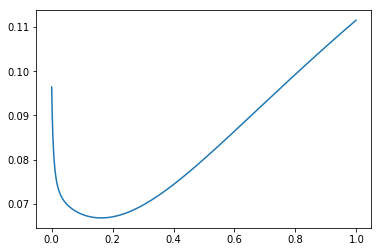

In [0]:
#Version 1 [8 points]

#6 points
c1train=np.log(SALE1_Training["Customers"].values)
c1valid=np.log(SALE1_Validation["Customers"].values)
c1test=np.log(SALE1_Testing["Customers"].values)

c2train=SALE1_Training["Customers"].values
c2valid=SALE1_Validation["Customers"].values
c2test=SALE1_Testing["Customers"].values

ytrain=np.log(SALE1_Training["Sales"].values)
yvalid=np.log(SALE1_Validation["Sales"].values)
ytest=np.log(SALE1_Testing["Sales"].values)

c1train_sd=np.std(c1train)
c1train_mean=np.mean(c1train)
c2train_sd=np.std(c2train)
c2train_mean=np.mean(c2train)
ytrain_mean=np.mean(ytrain)

c1_train_standardized=(c1train-c1train_mean)/c1train_sd
c2_train_standardized=(c2train-c2train_mean)/c2train_sd
y_train_demeaned=ytrain-ytrain_mean

c1_valid_standardized=(c1valid-c1train_mean)/c1train_sd
c2_valid_standardized=(c2valid-c2train_mean)/c2train_sd
c1_test_standardized=(c1test-c1train_mean)/c1train_sd
c2_test_standardized=(c2test-c2train_mean)/c2train_sd

data1=pd.DataFrame({"y":y_train_demeaned,"c1":c1_train_standardized,"c2":c2_train_standardized})

def ridge_standardized(alpha_v):
  params_recovered=ols("y~c1+c2-1",data=data1).fit_regularized(alpha=alpha_v,L1_wt=0).params
  prediction=ytrain_mean+params_recovered[0]*c1_valid_standardized+params_recovered[1]*c2_valid_standardized
  prediction=np.exp(prediction)
  actual=np.exp(yvalid)
  return (np.mean(((prediction-actual)/actual)**2))**0.5

#2 points
alpha_array= np.arange(0.000000,1,0.001)
RSMPE_array=[ridge_standardized(alpha) for alpha in alpha_array]

plt.plot(alpha_array,RSMPE_array)

np.min(RSMPE_array)

0.06678143853497989

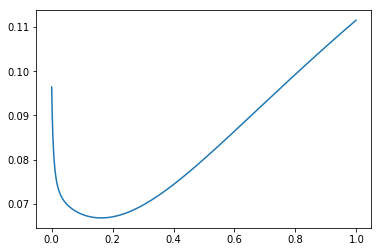

In [0]:
#Version 2 [8 points]

#6 points
c2train=SALE1_Training["Customers"].values
c1train=np.log(c2train)
y_train=np.log(SALE1_Training["Sales"].values)

#standardize then split
SALE2=SALE1.assign(x1=lambda x: (np.log(x.Customers)-np.mean(c1train))/np.std(c1train))
SALE2=SALE2.assign(x2=lambda x: (x.Customers-np.mean(c2train))/np.std(c2train))
SALE2=SALE2.assign(y=lambda x: (np.log(x.Sales)-np.mean(y_train)))

SALE2_Train=SALE2[SALE2["Date"]<="2013-02-01"]
SALE2_Valid=SALE2[(SALE2["Date"]>="2013-02-02") & (SALE1["Date"]<="2013-02-11")]
SALE2_Test=SALE2[(SALE2["Date"]>="2013-02-12")  ]

#ridge regression
def ridge_standardized(alpha_v):
  prediction=ols("y~x1+x2-1",data=SALE2_Train).fit_regularized(alpha=alpha_v,L1_wt=0).predict(SALE2_Valid)
  prediction=np.exp(prediction+np.mean(y_train))
  actual=SALE1_Validation["Sales"].values
  return (np.mean(((prediction-actual)/actual)**2))**0.5

#2 points
alpha_array= np.arange(0.000000,1,0.001)
RSMPE_array=[ridge_standardized(alpha) for alpha in alpha_array]

plt.plot(alpha_array,RSMPE_array)

np.min(RSMPE_array)

We can see that, again ridge helped reduced the RMSPE to 0.067. 
Since the ridge when the standardized/demeaned model works better. We will choose this as our final model.

In [0]:
#best alpha

#Determine the best method [1 point]
#The second method helped to reduce the RMSPE to 0.067, which is lower than the lowest RMSPE we got using the first method.
#Since the ridge when the standardized/demeaned model works better. We will choose this as our final model.


#determine the best alpha [2 point]
#If a student's alpha is gotten from trial and error, but close enough, deduct 1 point.
best_alpha=alpha_array[np.argmin(RSMPE_array)]
best_alpha

0.163

In [0]:
#measure accuracy on the testing set [2 points]

def ridge_testing(alpha_v):
  prediction=ols("y~x1+x2-1",data=SALE2_Train).fit_regularized(alpha=alpha_v,L1_wt=0).predict(SALE2_Test)
  prediction=np.exp(prediction+np.mean(y_train))
  actual=SALE1_Testing["Sales"].values
  return (np.mean(((prediction-actual)/actual)**2))**0.5
ridge_testing(best_alpha)

0.12215861956171395

In [0]:
###Special Notice:
###If a student did not standardize the validation and testing using mean and std from the training set, 
#deduct 2 points.


###If a student used Ridge from sklearn for convenience, they have to produce the same result.
###If they used special arguments to avoid manual normalization and de-centering, they need
###to give explanation on what they are doing. If they simply use Ridge(Normalize=True, Intercept=False) from sklearn,
###deduct 4 points.

##Q*. Bonus question [3 points]

Do the task in Q5 but with the following factors with the help of `for` loop

* Promo
* SchoolHoliday
* C(Store)
* C(DayOfWeek)
* C(Store):np.log(Customers)
* C(Month)
* C(Year)
* C(StateHoliday)



In [0]:
###This is a bonus question. 
###Award 3 points only to students whose code is around the same efficiency as the following code

#If anything looks manual (in other words, cannot flexible handle a different set of candiate variables), deduct at least 1 point 
#If the general algorithm is wrong, deduct at least 2 points
#No output of the result from each stage selection. deduct 0.5 point

In [0]:
candidate_variables=np.array(["Promo","SchoolHoliday","C(Store)","C(DayOfWeek)",\
                              "C(Store):np.log(Customers)","C(Date.dt.month)","C(Date.dt.month)","C(StateHoliday)"])

full=len(candidate_variables)
best_model="np.log(Sales)~np.log(Customers)"
BEST_RMSPE=np.inf
actual=SALE_Validation["Sales"].values
for i in np.arange(full-1,-1,-1):
  RMSPE=np.empty(i+1)
  for j in range(i+1):
    candidate_formula=best_model+"+"+candidate_variables[j]
    prediction=ols(formula=candidate_formula,data=SALE_Training).fit().predict(SALE_Validation)
    prediction=np.exp(prediction)
    RMSPE[j]=(np.mean(((prediction-actual)/actual)**2))**0.5
  print(RMSPE)
  if BEST_RMSPE>np.min(RMSPE):
    Add_i=np.where(RMSPE==np.min(RMSPE))[0][0]
    best_model=best_model+"+"+candidate_variables[Add_i]
    #print(Add_i)
    print("variable added:", candidate_variables[Add_i])
   # print(best_model)
    BEST_RMSPE=np.min(RMSPE)
    candidate_variables=np.delete(candidate_variables,Add_i)    
  else:
    break
best_model

    

[0.1782979  0.19374863 0.08735008 0.19282693 0.08739037 0.1931646
 0.1931646  0.19377047]
variable added: C(Store)
[0.07348831 0.08729256 0.08706957 0.08433224 0.09152524 0.09152524
 0.08723028]
variable added: Promo
[0.07349231 0.07026419 0.07044447 0.0798118  0.0798118  0.07319869]
variable added: C(DayOfWeek)
[0.06999212 0.06835565 0.07724861 0.07724861 0.07000984]
variable added: C(Store):np.log(Customers)
[0.06811903 0.07524773 0.07524773 0.06812951]
variable added: SchoolHoliday
[0.07474376 0.07474376 0.06783796]
variable added: C(StateHoliday)
[0.07471457 0.07471457]


'np.log(Sales)~np.log(Customers)+C(Store)+Promo+C(DayOfWeek)+C(Store):np.log(Customers)+SchoolHoliday+C(StateHoliday)'

In [0]:
formula1='np.log(Sales)~np.log(Customers)+C(Store)+Promo+C(DayOfWeek)+C(Store):np.log(Customers)+SchoolHoliday+C(StateHoliday)'

#Final accuracy
prediction1=np.exp(ols(formula=formula1,data=SALE_Training).fit().predict(SALE_Testing))
actual_testing=SALE_Testing["Sales"]
RMSPE_testing=(np.mean(((prediction1-actual_testing)/actual_testing)**2))**0.5

print("Final accuracy on testing is:", RMSPE_testing)

Final accuracy on testing is: 0.08178377721956313
